In [103]:
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [105]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'horse','ship', 'truck'}

background_classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog'}

# print(type(foreground_classes))

In [0]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

In [0]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

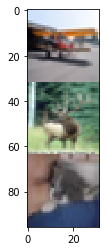

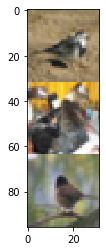

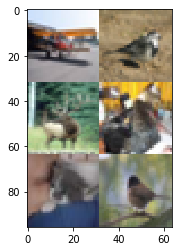

torch.Size([3, 96, 32])


In [109]:
img1 = torch.cat((background_data[0],background_data[1],background_data[2]),1)
imshow(img1)
img2 = torch.cat((background_data[27],background_data[3],background_data[43]),1)
imshow(img2)
img3 = torch.cat((img1,img2),2)
imshow(img3)
print(img2.size())


In [0]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]-7  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [0]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)



4


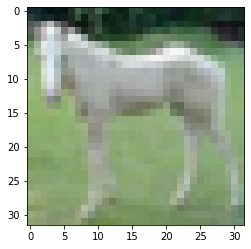

horse


In [112]:
qw=45

print(fore_idx[qw])
imshow(mosaic_list_of_images[qw][fore_idx[qw]])
# print(mosaic_list_of_images[0])
print(classes[mosaic_label[qw]+7]) # add 7 as we had subtracted 7 while saving

# imshow(mosaic_list_of_images[13][2])
# print(type(mosaic_list_of_images[1][0]))
# print(mosaic_label)

In [0]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Module1(nn.Module):
  def __init__(self):
    super(Module1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,1)

  def forward(self, z):
    x = torch.zeros([batch,9],dtype=torch.float64)
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x,y = x.to("cuda"),y.to("cuda")
    for i in range(9):
      x[:,i] = self.helper(z[:,i])[:,0]
    x = F.softmax(x,dim=1)   # alphas
    
    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])
    return y , x 
  
  def helper(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x
      


In [0]:
 class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,y):  #z batch of list of 9 images
    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    y1 = y1.view(-1, 16 * 5 * 5)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 


In [0]:
where_net = Module1().double()
where_net = where_net.to("cuda")
# print(net.parameters)

In [0]:
# idx = np.random.randint(0,250,10)
# train_iter = iter(train_loader)
# images,labels,_=train_iter.next()

# for i in idx:
#   imshow(where_net1(images)[i].detach().numpy())

In [0]:
what_net = Module2().double()
what_net = what_net.to("cuda")

In [0]:
# where_net.load_state_dict(torch.load("model_epoch90.pt"))
# what_net.load_state_dict(torch.load("model_epoch90.pt"))
# print(fore_net.parameters)

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [0]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [122]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer_where = optim.SGD(where_net.parameters(), lr=0.01, momentum=0.9)
optimizer_what = optim.SGD(what_net.parameters(), lr=0.01, momentum=0.9)

nos_epochs = 200
every_what_epoch = 10
#---------------------------------------------
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0
argmax_more_than_half = 0
argmax_less_than_half =0
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]
#-----------------------------------------------
train_loss=[]
test_loss =[]
train_acc = []
test_acc = []
for epoch in range(nos_epochs):  # loop over the dataset multiple times
    
  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  batch_correct = 0.0
  cnt=0
  total=0
  iteration = desired_num // batch



  #training data set

  if (epoch % (every_what_epoch*2) ) < every_what_epoch :
      print(epoch,"updating what_net, where_net is freezed")
  elif (epoch % (every_what_epoch*2)) > every_what_epoch :
      print(epoch,"updating where_net, what_net is freezed")
    
  for i, data in  enumerate(train_loader):
      inputs , labels , fore_idx = data
      inputs,labels = inputs.to("cuda"),labels.to("cuda") 
      # zero the parameter gradients
      
      optimizer_what.zero_grad()
      optimizer_where.zero_grad()
      
      avg_images , alphas = where_net(inputs)
      outputs = what_net(avg_images)
      
      _, predicted = torch.max(outputs.data, 1)
      

      loss = criterion(outputs, labels) 
      loss.backward() 
  
      if (epoch % (every_what_epoch*2) ) < every_what_epoch :
          optimizer_what.step()
      elif (epoch % (every_what_epoch*2)) > every_what_epoch :
          optimizer_where.step()
      batch_correct += sum(predicted == labels)
      total += len(predicted)
      running_loss += loss.item()
      if cnt % 120 == 119:    # print every 40 mini-batches
          print("--"*40)
          print("Epoch: ",epoch)
#             print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 120))
          train_loss.append(running_loss/120)
          train_acc.append(batch_correct.item()/desired_num)
          print("total_Correct:",batch_correct.item(),"Total:",total,"train_loss",running_loss/120,"train_acc: ", batch_correct.item()/total)
          #running_loss = 0.0
      cnt=cnt+1

      if epoch % 5 == 0:
        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1

  if epoch % 5 == 0:
    col1.append(epoch)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
  
    with torch.no_grad():
      loss = 0.0
      correct = 0.0
      tot =0
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0
      argmax_more_than_half = 0
      argmax_less_than_half =0

      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs,labels = inputs.to("cuda"),labels.to("cuda") 
        avg_images , alphas = where_net(inputs)
        outputs = what_net(avg_images)
        _, predicted = torch.max(outputs.data, 1)
        loss += criterion(outputs, labels).item() 
        correct += sum(predicted == labels)
        tot += len(predicted)

        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1
          
      test_loss.append(loss/40) # 10000/250 = 40
      test_acc.append(correct.item()/tot)
      print("total_Correct:",correct.item(),"Total:",tot,"test loss: ", loss/40, "test accuracy", correct.item()/tot)

    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)

  elif epoch % 5 != 0  :
    with torch.no_grad():
      loss = 0.0
      correct = 0.0
      tot =0
      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs,labels = inputs.to("cuda"),labels.to("cuda") 
        avg_images , alphas = where_net(inputs)
        outputs = what_net(avg_images)
        _, predicted = torch.max(outputs.data, 1)
        loss += criterion(outputs, labels).item() 
        correct += sum(predicted == labels)
        tot += len(predicted)

      test_loss.append(loss/40) # 10000/250 = 40
      test_acc.append(correct.item()/tot)
      print("total_Correct:",correct.item(),"Total:",tot,"test loss: ", loss/40, "test accuracy", correct.item()/tot)
 
    
  if (epoch % (every_what_epoch*2) == every_what_epoch*2 - 1):
      torch.save(where_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/alternate_training_200_every10epochs_lr_01/where_model_at_epoch"+str(epoch)+".pt")
      torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/alternate_training_200_every10epochs_lr_01/what_model_at_epoch"+str(epoch)+".pt")
    
print('Finished Training')
torch.save(where_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/alternate_training_200_every10epochs_lr_01/full_where_model_epoch"+str(nos_epochs)+".pt")
torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/alternate_training_200_every10epochs_lr_01/full_what_model_epoch"+str(nos_epochs)+".pt")

0 updating what_net, where_net is freezed
--------------------------------------------------------------------------------
Epoch:  0
total_Correct: 10122.0 Total: 30000 train_loss 1.1015764913982578 train_acc:  0.3374
total_Correct: 3413.0 Total: 10000 test loss:  1.0983953178806427 test accuracy 0.3413
1 updating what_net, where_net is freezed
--------------------------------------------------------------------------------
Epoch:  1
total_Correct: 10129.0 Total: 30000 train_loss 1.098653322373949 train_acc:  0.33763333333333334
total_Correct: 3344.0 Total: 10000 test loss:  1.0985637027097412 test accuracy 0.3344
2 updating what_net, where_net is freezed
--------------------------------------------------------------------------------
Epoch:  2
total_Correct: 10098.0 Total: 30000 train_loss 1.0986463770684372 train_acc:  0.3366
total_Correct: 3344.0 Total: 10000 test loss:  1.0986493202017715 test accuracy 0.3344
3 updating what_net, where_net is freezed
-------------------------------

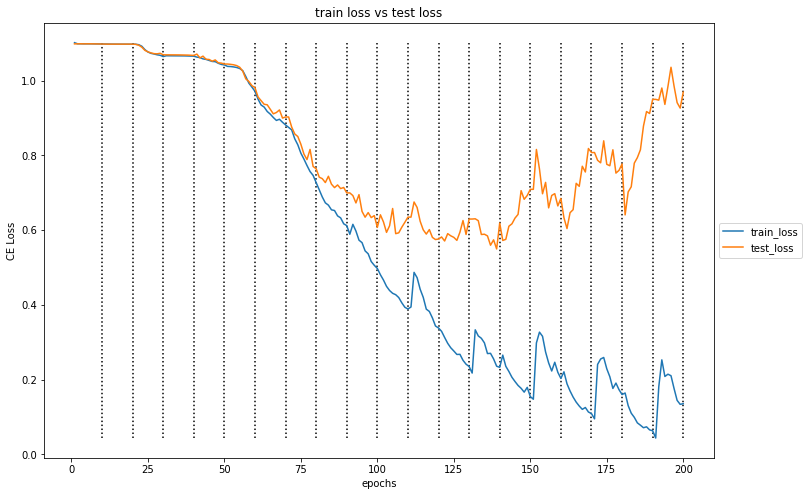

In [123]:
fig = plt.figure(figsize = (12,8) )
vline_list = np.arange(every_what_epoch, nos_epochs + every_what_epoch, every_what_epoch )
# train_loss = np.random.randn(340)
# test_loss = np.random.randn(340)
epoch_list = np.arange(1, nos_epochs+1)
plt.plot(epoch_list,train_loss, label='train_loss')
plt.plot(epoch_list,test_loss, label='test_loss')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("CE Loss")
plt.vlines(vline_list,min(min(train_loss),min(test_loss)), max(max(test_loss),max(train_loss)),linestyles='dotted')
plt.title("train loss vs test loss")
plt.show()
fig.savefig("train_test_loss_plot.pdf")


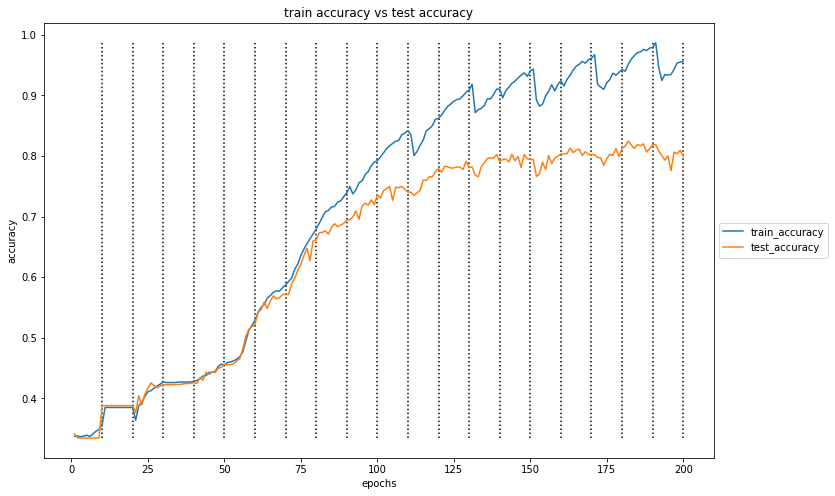

In [124]:
fig = plt.figure(figsize = (12,8) )
vline_list = np.arange(every_what_epoch, nos_epochs + every_what_epoch, every_what_epoch )
# train_acc = np.random.randn(340)
# test_acc = np.random.randn(340)
epoch_list = np.arange(1, nos_epochs+1)
plt.plot(epoch_list,train_acc, label='train_accuracy')
plt.plot(epoch_list,test_acc, label='test_accuracy')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.vlines(vline_list,min(min(train_acc),min(test_acc)), max(max(test_acc),max(train_acc)),linestyles='dotted')
plt.title("train accuracy vs test accuracy")
plt.show()
fig.savefig("train_test_acc_plot.pdf")

In [0]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [126]:
df_train

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0        0             0  ...                   3065                   16813
1        5             0  ...                   3063                   16832
2       10             0  ...                   2911                   15543
3       15             0  ...                   2957                   15498
4       20             0  ...                   2991                   16099
5       25             0  ...                   3172                   14451
6       30             0  ...                   2959                   14262
7       35             0  ...                   2147                   15050
8       40             0  ...                   1671                   15446
9       45             0  ...                   1559                   15157
10      50             0  ...                   1513                   14710
11      55             0  ...                   4193                   11520
12      60          5585  ...                   3474                   10269
13      65          5585  ...                   2769                    9983
14      70          5585  ...                   2404                    9809
15      75         14230  ...                   2523                    8088
16      80         17433  ...                   2633                    6703
17      85         17433  ...                   2048                    6454
18      90         17433  ...                   1581                    5930
19      95         20273  ...                   1715                    5212
20     100         20250  ...                   1732                    4319
21     105         20250  ...                   1251                    4017
22     110         20250  ...                   1019                    3944
23     115         22229  ...                    938                    3813
24     120         23817  ...                    938                    3030
25     125         23817  ...                    610                    2597
26     130         23817  ...                    431                    2017
27     135         22965  ...                    691                    2475
28     140         24790  ...                    661                    2460
29     145         24790  ...                    355                    1779
30     150         24790  ...                    314                    1378
31     155         23982  ...                    666                    2136
32     160         25445  ...                    536                    2004
33     165         25445  ...                    202                    1257
34     170         25445  ...                    156                     827
35     175         24342  ...                    507                    1710
36     180         25991  ...                    400                    1404
37     185         25991  ...                    138                     708
38     190         25991  ...                     44                     345
39     195         23548  ...                    482                    1483

[40 rows x 7 columns]

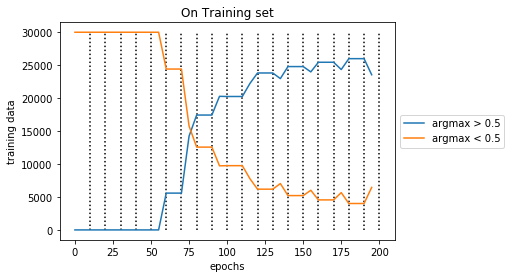

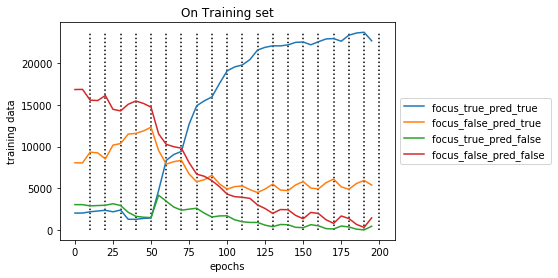

In [127]:
# plt.figure(12,12)
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.vlines(vline_list,min(min(col2),min(col3)), max(max(col2),max(col3)),linestyles='dotted')
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.vlines(vline_list,min(min(col4),min(col5),min(col6),min(col7)), max(max(col4),max(col5),max(col6),max(col7)),linestyles='dotted')
plt.show()

In [128]:
df_test

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0        0             0  ...                   1073                    5514
1        5             0  ...                    986                    5670
2       10             0  ...                    914                    5207
3       15             0  ...                    925                    5196
4       20             0  ...                   1014                    5221
5       25             0  ...                   1033                    4715
6       30             0  ...                    954                    4824
7       35             0  ...                    706                    5062
8       40             0  ...                    485                    5270
9       45             0  ...                    543                    5022
10      50             0  ...                    516                    4928
11      55             0  ...                   1300                    3893
12      60          1850  ...                   1180                    3405
13      65          1850  ...                    953                    3359
14      70          1850  ...                    833                    3450
15      75          4442  ...                    883                    2761
16      80          5673  ...                    820                    2449
17      85          5673  ...                    716                    2402
18      90          5673  ...                    652                    2402
19      95          6812  ...                    674                    2106
20     100          6506  ...                    703                    1992
21     105          6506  ...                    573                    1943
22     110          6506  ...                    593                    2005
23     115          6757  ...                    564                    1839
24     120          7587  ...                    577                    1690
25     125          7587  ...                    470                    1711
26     130          7587  ...                    477                    1707
27     135          7538  ...                    465                    1576
28     140          7968  ...                    430                    1629
29     145          7968  ...                    433                    1576
30     150          7968  ...                    479                    1579
31     155          7860  ...                    497                    1495
32     160          8195  ...                    410                    1553
33     165          8195  ...                    423                    1464
34     170          8195  ...                    429                    1549
35     175          7684  ...                    516                    1456
36     180          8291  ...                    478                    1363
37     185          8291  ...                    414                    1417
38     190          8291  ...                    407                    1406
39     195          7002  ...                    578                    1664

[40 rows x 7 columns]

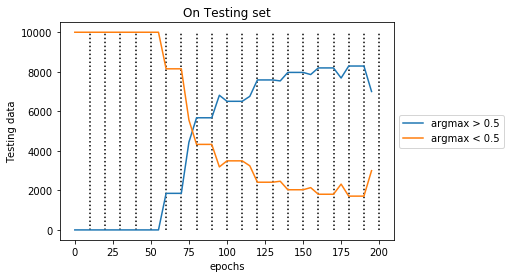

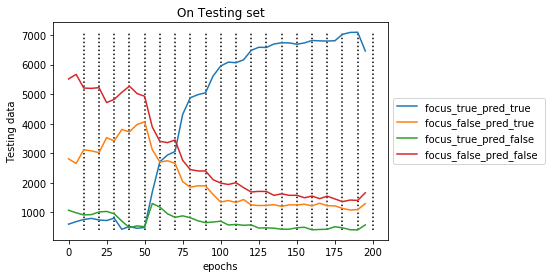

In [129]:
# plt.figure(12,12)
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.vlines(vline_list,min(min(col8),min(col9)), max(max(col8),max(col9)),linestyles='dotted')
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.vlines(vline_list,min(min(col10),min(col11),min(col12),min(col13)), max(max(col10),max(col11),max(col12),max(col13)),linestyles='dotted')
plt.show()

In [130]:
print("-"*20,"Training Dataset","-"*20)
print("epochs", col1) 
print("argmax > 0.5 ", col2) 
print("argmax < 0.5 ", col3) 
print("focus_true_pred_true", col4) 
print("focus_false_pred_true", col5)
print("focus_true_pred_false", col6) 
print("focus_false_pred_false", col7) 
print("-"*20,"Testing Dataset","-"*20)
print("argmax > 0.5 ", col8)
print("argmax < 0.5", col9) 
print("focus_true_pred_true", col10) 
print("focus_false_pred_true", col11)
print("focus_true_pred_false", col12) 
print("focus_false_pred_false", col13) 

-------------------- Training Dataset --------------------
epochs [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195]
argmax > 0.5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5585, 5585, 5585, 14230, 17433, 17433, 17433, 20273, 20250, 20250, 20250, 22229, 23817, 23817, 23817, 22965, 24790, 24790, 24790, 23982, 25445, 25445, 25445, 24342, 25991, 25991, 25991, 23548]
argmax < 0.5  [30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 30000, 24415, 24415, 24415, 15770, 12567, 12567, 12567, 9727, 9750, 9750, 9750, 7771, 6183, 6183, 6183, 7035, 5210, 5210, 5210, 6018, 4555, 4555, 4555, 5658, 4009, 4009, 4009, 6452]
focus_true_pred_true [2056, 2058, 2210, 2303, 2387, 2206, 2419, 1316, 1307, 1419, 1465, 4759, 8350, 9055, 9420, 12659, 14875, 15460, 15927, 17533, 19035, 19516, 19748, 20390, 21530, 21858, 22037, 22026, 22144, 22450, 22491, 22157, 22521,

In [0]:
df_train.to_csv("/content/drive/My Drive/Research/stage_wise_training/alternate_training_200_every10epochs_lr_01/focus_vs_predicted_train.csv")
df_test.to_csv("/content/drive/My Drive/Research/stage_wise_training/alternate_training_200_every10epochs_lr_01/focus_vs_predicted_test.csv")

In [0]:
def display(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

****************************************************************************************************


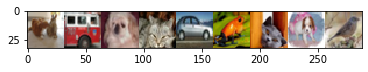

tensor([4.1149e-02, 3.8002e-02, 4.7458e-02, 2.9003e-03, 7.8471e-01, 5.3607e-04,
        3.8943e-03, 7.3844e-02, 7.5037e-03], device='cuda:0',
       dtype=torch.float64)


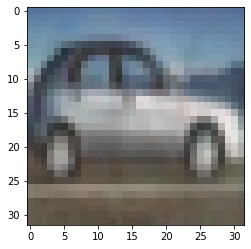

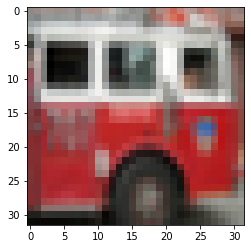

predicted horse
true truck
****************************************************************************************************


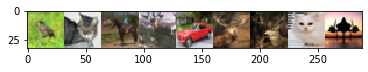

tensor([1.1158e-06, 3.5610e-02, 8.3985e-02, 7.8413e-01, 5.7182e-05, 1.2083e-03,
        1.4713e-03, 2.2204e-04, 9.3312e-02], device='cuda:0',
       dtype=torch.float64)


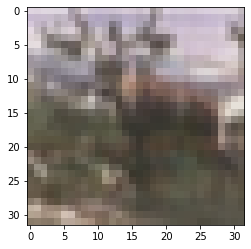

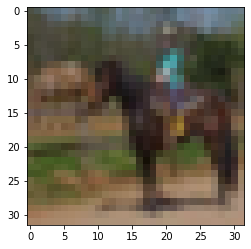

predicted horse
true horse
****************************************************************************************************


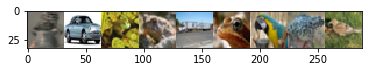

tensor([6.3840e-02, 4.3229e-04, 1.3007e-04, 2.3085e-02, 8.7478e-01, 1.2310e-02,
        5.6281e-05, 2.4704e-02, 6.6263e-04], device='cuda:0',
       dtype=torch.float64)


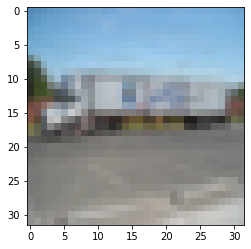

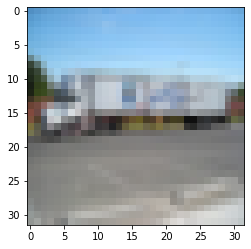

predicted truck
true truck
****************************************************************************************************


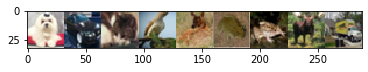

tensor([3.4125e-05, 4.5524e-02, 5.7629e-03, 7.6314e-03, 4.1670e-04, 1.5695e-03,
        1.9476e-03, 7.2010e-03, 9.2991e-01], device='cuda:0',
       dtype=torch.float64)


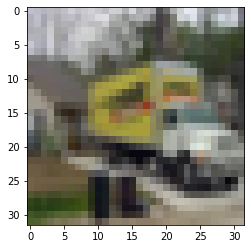

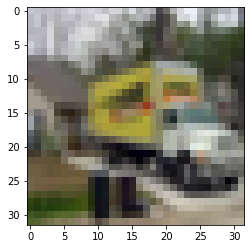

predicted truck
true truck
****************************************************************************************************


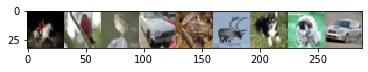

tensor([0.0059, 0.0054, 0.0271, 0.6847, 0.0034, 0.1652, 0.0009, 0.0249, 0.0824],
       device='cuda:0', dtype=torch.float64)


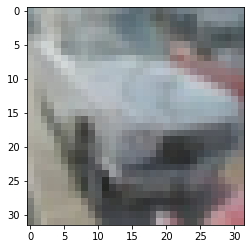

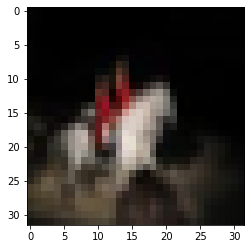

predicted horse
true horse
****************************************************************************************************


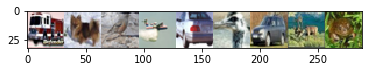

tensor([8.7273e-01, 2.7450e-02, 7.5495e-02, 4.8132e-03, 3.0780e-03, 4.6934e-03,
        1.0463e-03, 1.0022e-02, 6.6844e-04], device='cuda:0',
       dtype=torch.float64)


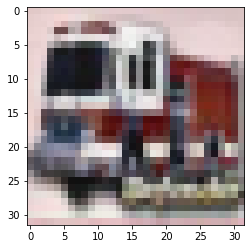

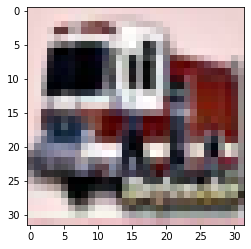

predicted truck
true truck
****************************************************************************************************


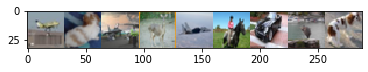

tensor([1.5116e-02, 4.9747e-03, 4.5626e-02, 1.0790e-03, 2.7612e-03, 9.2529e-01,
        3.7047e-04, 3.8367e-03, 9.5040e-04], device='cuda:0',
       dtype=torch.float64)


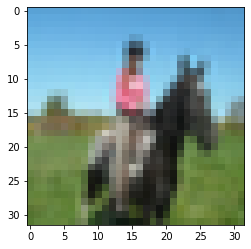

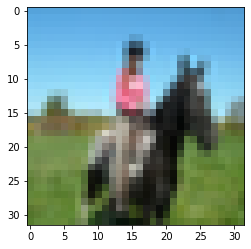

predicted horse
true horse
****************************************************************************************************


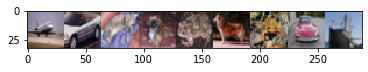

tensor([1.0895e-02, 3.3112e-04, 5.2964e-03, 1.0818e-03, 2.1017e-03, 1.7654e-03,
        1.7801e-04, 3.4178e-02, 9.4417e-01], device='cuda:0',
       dtype=torch.float64)


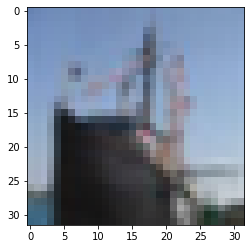

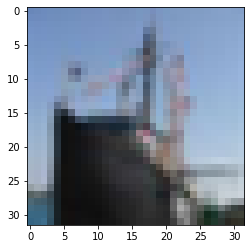

predicted ship
true ship
****************************************************************************************************


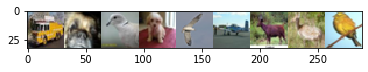

tensor([6.0127e-01, 4.2986e-02, 8.6858e-02, 7.8747e-03, 1.1193e-01, 7.8248e-02,
        7.0750e-02, 8.1055e-05, 5.7065e-07], device='cuda:0',
       dtype=torch.float64)


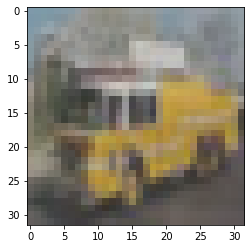

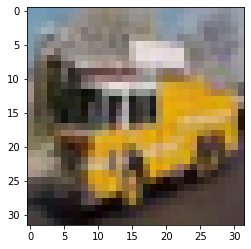

predicted truck
true truck
****************************************************************************************************


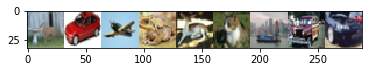

tensor([1.5214e-02, 3.6861e-02, 2.4368e-03, 4.6579e-03, 4.1218e-02, 2.2567e-04,
        7.5417e-01, 9.2906e-02, 5.2313e-02], device='cuda:0',
       dtype=torch.float64)


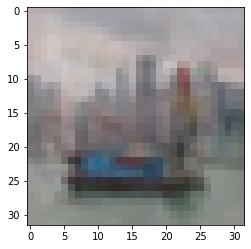

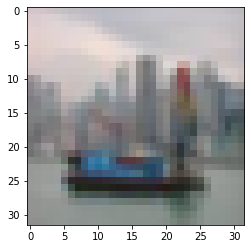

predicted ship
true ship
****************************************************************************************************


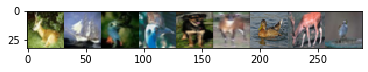

tensor([5.1004e-05, 8.5675e-01, 6.9689e-04, 1.2901e-03, 3.7940e-02, 5.6923e-02,
        8.1676e-03, 9.3423e-03, 2.8839e-02], device='cuda:0',
       dtype=torch.float64)


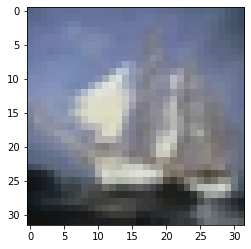

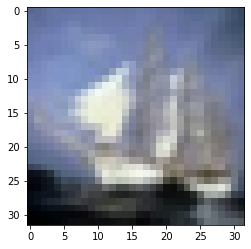

predicted ship
true ship
****************************************************************************************************


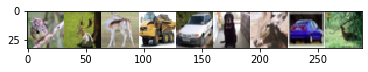

tensor([2.3209e-02, 9.3724e-07, 4.8203e-03, 2.2221e-01, 1.5631e-03, 5.3769e-01,
        1.9609e-01, 1.3736e-02, 6.7789e-04], device='cuda:0',
       dtype=torch.float64)


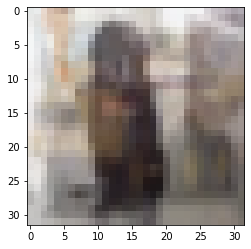

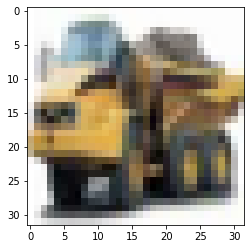

predicted horse
true truck
****************************************************************************************************


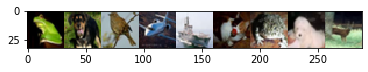

tensor([3.2955e-06, 7.4080e-02, 2.9328e-04, 1.9517e-02, 8.8106e-01, 5.7941e-04,
        2.2524e-02, 6.9047e-04, 1.2486e-03], device='cuda:0',
       dtype=torch.float64)


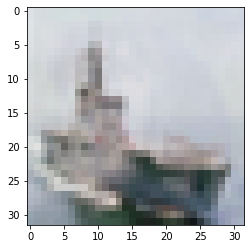

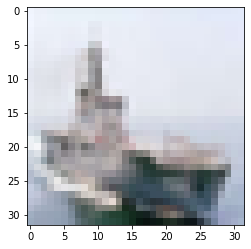

predicted ship
true ship
****************************************************************************************************


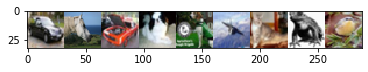

tensor([6.9700e-04, 8.4158e-01, 2.4281e-02, 3.9345e-05, 6.5462e-03, 1.1167e-01,
        8.0084e-03, 1.3527e-03, 5.8328e-03], device='cuda:0',
       dtype=torch.float64)


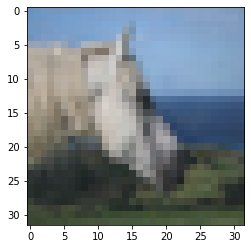

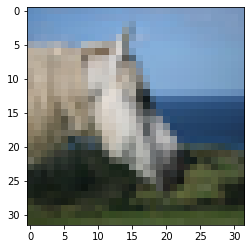

predicted horse
true horse
****************************************************************************************************


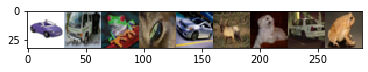

tensor([1.9659e-01, 7.5173e-01, 1.6328e-02, 1.0949e-02, 1.4731e-02, 4.1388e-03,
        1.3202e-04, 5.4064e-03, 4.6070e-06], device='cuda:0',
       dtype=torch.float64)


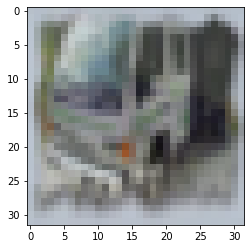

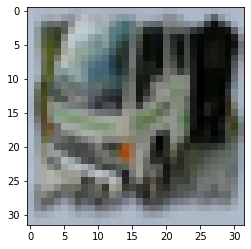

predicted truck
true truck
****************************************************************************************************


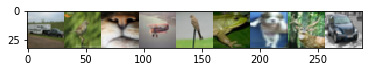

tensor([0.2701, 0.0012, 0.0046, 0.3604, 0.0338, 0.0103, 0.2057, 0.0094, 0.1044],
       device='cuda:0', dtype=torch.float64)


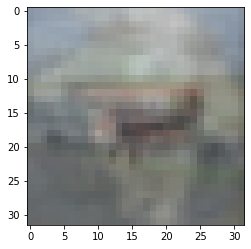

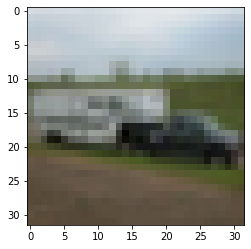

predicted truck
true truck
****************************************************************************************************


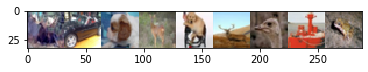

tensor([1.4971e-01, 2.0596e-02, 1.7320e-02, 1.5684e-03, 1.6372e-03, 2.2204e-02,
        2.3479e-03, 7.8399e-01, 6.2655e-04], device='cuda:0',
       dtype=torch.float64)


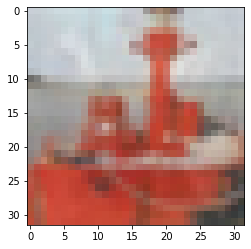

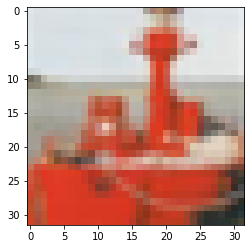

predicted ship
true ship
****************************************************************************************************


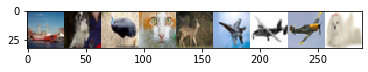

tensor([9.1559e-01, 4.8030e-05, 6.7700e-03, 3.3517e-03, 1.5904e-03, 5.5793e-04,
        3.1174e-03, 1.7966e-03, 6.7180e-02], device='cuda:0',
       dtype=torch.float64)


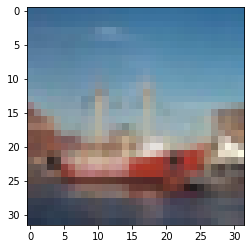

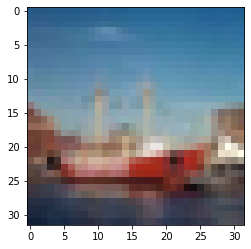

predicted ship
true ship
****************************************************************************************************


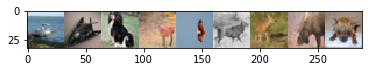

tensor([9.5394e-01, 4.7795e-03, 7.5280e-04, 1.3877e-03, 5.2489e-04, 2.7920e-02,
        1.2639e-04, 1.0566e-02, 5.1181e-06], device='cuda:0',
       dtype=torch.float64)


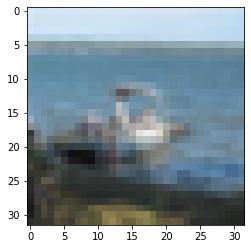

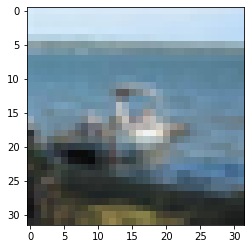

predicted ship
true ship
****************************************************************************************************


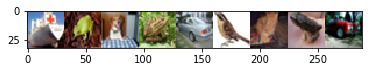

tensor([7.7524e-01, 5.1896e-07, 1.9116e-04, 6.0925e-03, 1.3863e-01, 1.5613e-02,
        1.2712e-04, 1.8024e-02, 4.6081e-02], device='cuda:0',
       dtype=torch.float64)


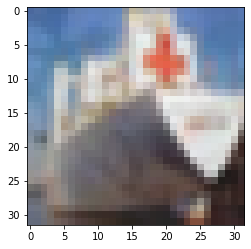

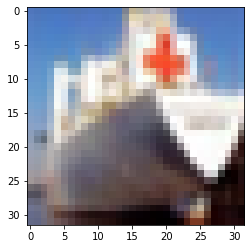

predicted ship
true ship
****************************************************************************************************


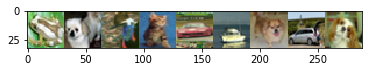

tensor([1.5636e-03, 6.7732e-03, 1.8707e-02, 3.4816e-02, 5.2519e-02, 8.0643e-01,
        5.0088e-03, 7.4073e-02, 1.0538e-04], device='cuda:0',
       dtype=torch.float64)


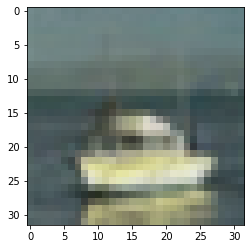

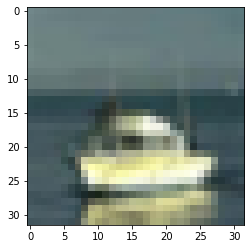

predicted ship
true ship
****************************************************************************************************


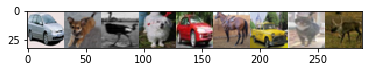

tensor([2.3671e-03, 1.8553e-03, 3.8352e-02, 5.3064e-04, 1.4807e-03, 9.2940e-01,
        1.1321e-02, 1.3757e-02, 9.3999e-04], device='cuda:0',
       dtype=torch.float64)


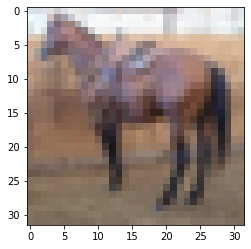

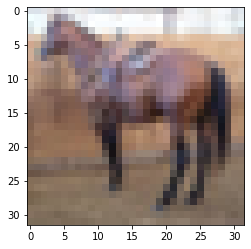

predicted horse
true horse
****************************************************************************************************


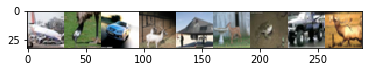

tensor([6.1579e-02, 2.7865e-04, 1.6560e-03, 1.5785e-03, 2.7853e-01, 1.7053e-02,
        2.0461e-03, 6.3512e-01, 2.1530e-03], device='cuda:0',
       dtype=torch.float64)


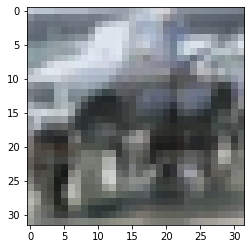

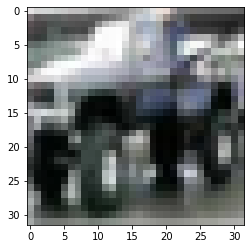

predicted truck
true truck
****************************************************************************************************


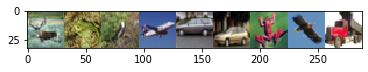

tensor([7.0131e-02, 7.5984e-05, 2.1281e-03, 3.0695e-02, 2.2473e-01, 2.4906e-03,
        8.5998e-03, 5.3905e-02, 6.0724e-01], device='cuda:0',
       dtype=torch.float64)


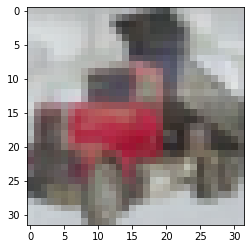

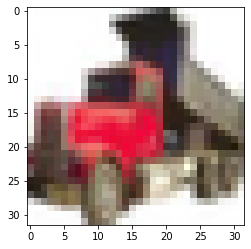

predicted truck
true truck
****************************************************************************************************


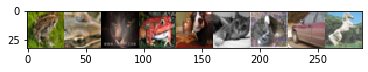

tensor([3.0663e-05, 5.8419e-03, 2.1365e-04, 1.3203e-03, 1.5710e-04, 1.4861e-03,
        3.1330e-02, 1.1681e-02, 9.4794e-01], device='cuda:0',
       dtype=torch.float64)


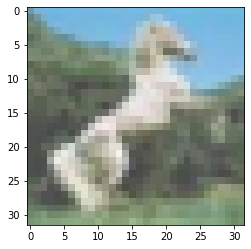

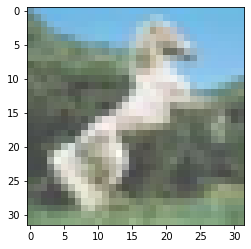

predicted horse
true horse
****************************************************************************************************


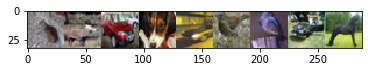

tensor([1.0004e-02, 8.3554e-02, 2.1166e-02, 6.1102e-04, 3.4054e-03, 3.6854e-03,
        4.5534e-02, 2.5738e-02, 8.0630e-01], device='cuda:0',
       dtype=torch.float64)


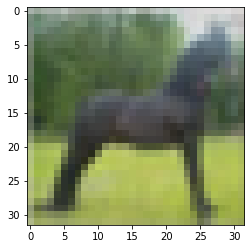

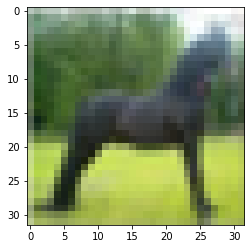

predicted horse
true horse
****************************************************************************************************


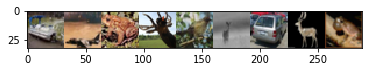

tensor([0.2479, 0.0254, 0.1069, 0.2508, 0.1863, 0.0869, 0.0308, 0.0641, 0.0008],
       device='cuda:0', dtype=torch.float64)


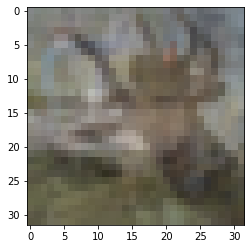

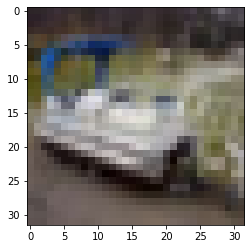

predicted horse
true ship
****************************************************************************************************


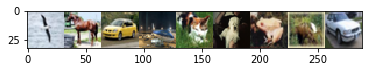

tensor([3.4549e-04, 9.2457e-01, 1.3732e-03, 5.7611e-02, 1.4058e-04, 4.8660e-06,
        1.3603e-04, 3.8402e-03, 1.1981e-02], device='cuda:0',
       dtype=torch.float64)


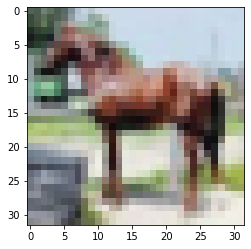

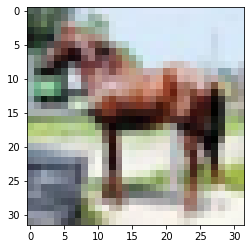

predicted horse
true horse
****************************************************************************************************


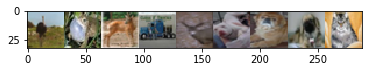

tensor([3.6700e-03, 8.8623e-04, 3.4120e-03, 9.2848e-01, 4.9892e-03, 1.9821e-02,
        8.7175e-03, 2.3051e-02, 6.9755e-03], device='cuda:0',
       dtype=torch.float64)


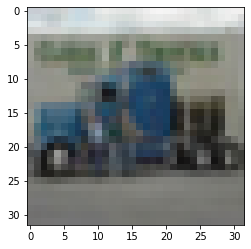

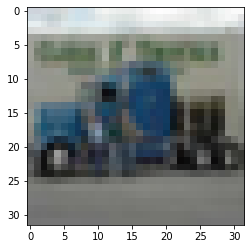

predicted truck
true truck
****************************************************************************************************


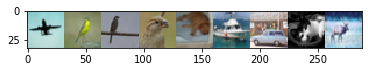

tensor([3.4810e-03, 1.6064e-05, 5.0238e-01, 3.0438e-04, 1.5640e-03, 4.2168e-01,
        3.7046e-02, 3.2683e-02, 8.4516e-04], device='cuda:0',
       dtype=torch.float64)


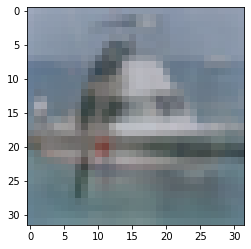

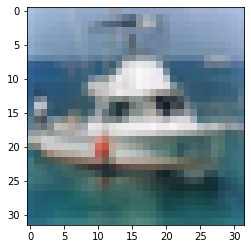

predicted ship
true ship
****************************************************************************************************


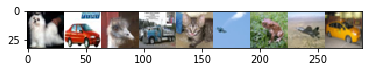

tensor([1.0658e-04, 2.2823e-02, 1.0066e-03, 7.8868e-01, 1.0017e-01, 5.0211e-03,
        1.3571e-02, 6.8011e-02, 6.0829e-04], device='cuda:0',
       dtype=torch.float64)


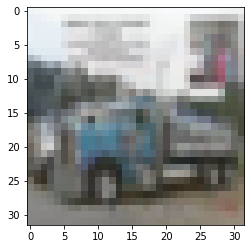

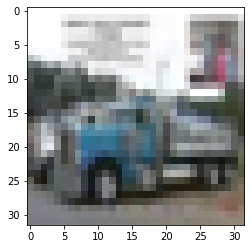

predicted truck
true truck
****************************************************************************************************


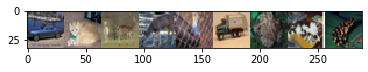

tensor([0.4698, 0.0038, 0.0189, 0.1329, 0.0078, 0.2147, 0.0573, 0.0243, 0.0706],
       device='cuda:0', dtype=torch.float64)


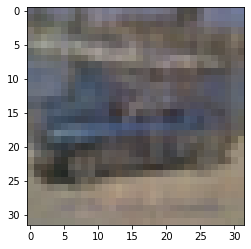

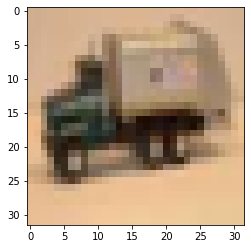

predicted truck
true truck
****************************************************************************************************


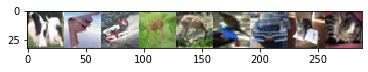

tensor([0.0419, 0.0074, 0.4999, 0.0008, 0.1723, 0.0023, 0.0998, 0.1543, 0.0212],
       device='cuda:0', dtype=torch.float64)


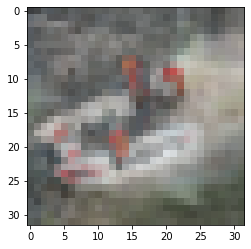

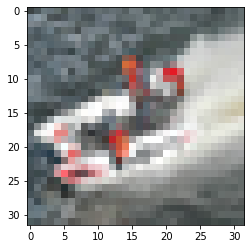

predicted ship
true ship
****************************************************************************************************


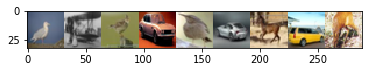

tensor([0.2645, 0.1831, 0.0007, 0.0138, 0.0008, 0.0334, 0.3650, 0.0967, 0.0420],
       device='cuda:0', dtype=torch.float64)


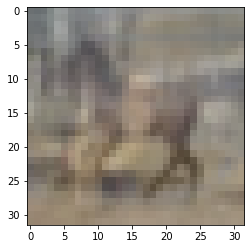

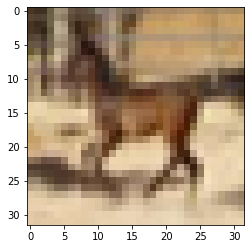

predicted horse
true horse
****************************************************************************************************


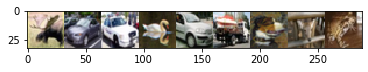

tensor([2.1917e-03, 2.4776e-03, 1.5219e-04, 5.8007e-03, 9.2904e-02, 8.9444e-01,
        1.5788e-03, 4.1491e-04, 3.6845e-05], device='cuda:0',
       dtype=torch.float64)


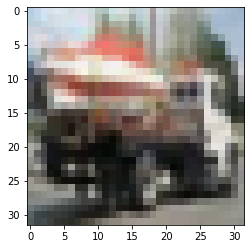

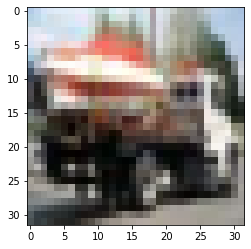

predicted truck
true truck
****************************************************************************************************


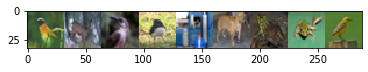

tensor([0.0095, 0.6893, 0.0076, 0.0623, 0.1491, 0.0102, 0.0609, 0.0021, 0.0089],
       device='cuda:0', dtype=torch.float64)


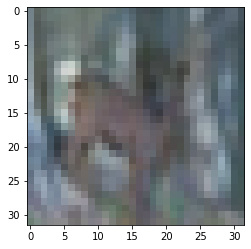

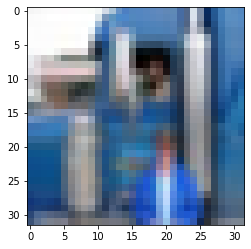

predicted truck
true truck
****************************************************************************************************


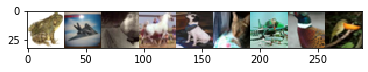

tensor([1.4129e-03, 1.2163e-01, 1.8956e-03, 8.6052e-01, 5.4886e-04, 1.4182e-03,
        1.1691e-02, 8.7626e-04, 9.7274e-06], device='cuda:0',
       dtype=torch.float64)


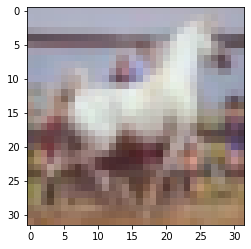

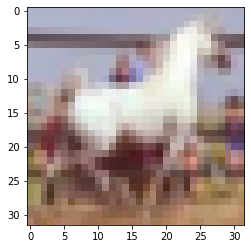

predicted horse
true horse
****************************************************************************************************


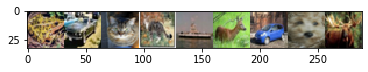

tensor([3.7442e-05, 8.9143e-03, 1.7054e-03, 4.7250e-03, 9.8325e-01, 1.6167e-04,
        1.4637e-04, 6.9678e-04, 3.6098e-04], device='cuda:0',
       dtype=torch.float64)


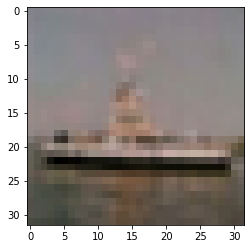

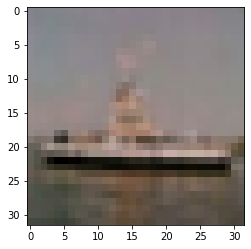

predicted ship
true ship
****************************************************************************************************


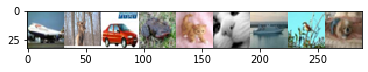

tensor([0.1371, 0.1146, 0.0177, 0.0214, 0.0086, 0.0011, 0.6213, 0.0464, 0.0318],
       device='cuda:0', dtype=torch.float64)


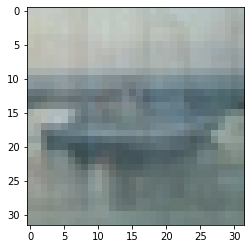

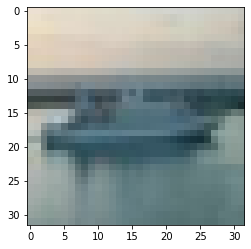

predicted ship
true ship
****************************************************************************************************


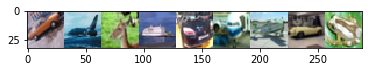

tensor([7.3461e-03, 7.0305e-03, 3.5076e-05, 6.8925e-01, 1.3661e-01, 3.1019e-03,
        1.2548e-01, 3.1011e-02, 1.2900e-04], device='cuda:0',
       dtype=torch.float64)


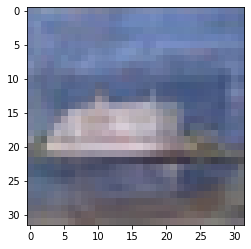

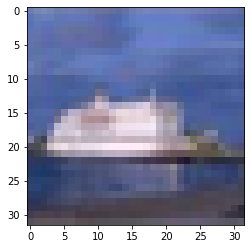

predicted ship
true ship
****************************************************************************************************


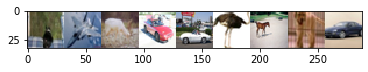

tensor([0.0145, 0.0819, 0.3251, 0.0066, 0.0812, 0.0074, 0.0952, 0.0086, 0.3793],
       device='cuda:0', dtype=torch.float64)


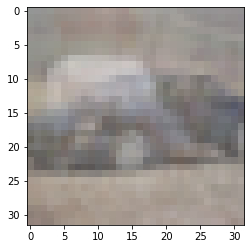

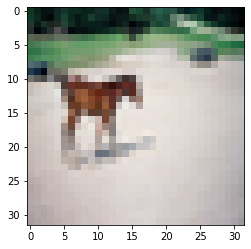

predicted ship
true horse
****************************************************************************************************


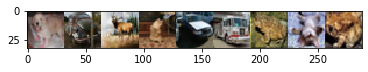

tensor([3.1206e-04, 6.4139e-02, 2.9880e-01, 2.2908e-03, 1.7499e-01, 7.4800e-02,
        1.4623e-04, 3.8344e-01, 1.0844e-03], device='cuda:0',
       dtype=torch.float64)


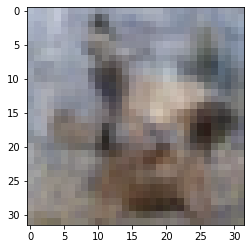

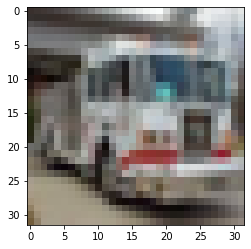

predicted ship
true truck
****************************************************************************************************


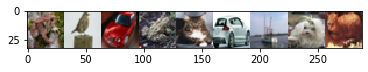

tensor([9.4889e-02, 1.8716e-03, 5.8023e-04, 2.5780e-02, 1.5139e-02, 8.6599e-03,
        7.6037e-01, 5.0874e-02, 4.1832e-02], device='cuda:0',
       dtype=torch.float64)


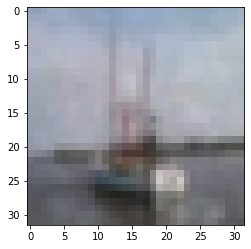

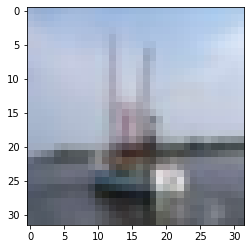

predicted ship
true ship
****************************************************************************************************


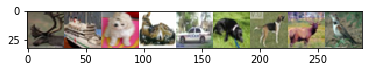

tensor([0.0078, 0.4042, 0.0007, 0.2082, 0.2242, 0.0261, 0.0252, 0.0354, 0.0681],
       device='cuda:0', dtype=torch.float64)


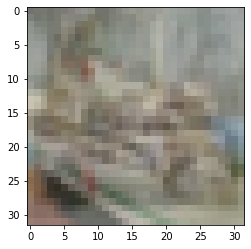

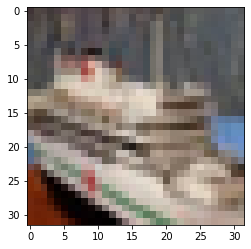

predicted ship
true ship
****************************************************************************************************


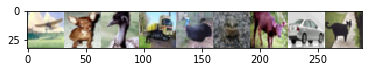

tensor([1.5713e-01, 9.9409e-05, 3.0123e-04, 8.0257e-01, 9.9958e-03, 2.5831e-02,
        1.2136e-03, 1.6097e-03, 1.2455e-03], device='cuda:0',
       dtype=torch.float64)


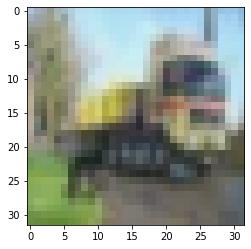

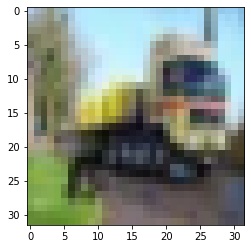

predicted truck
true truck
****************************************************************************************************


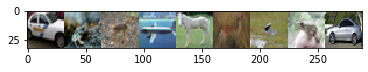

tensor([2.0511e-02, 6.1711e-02, 1.2531e-02, 9.6411e-03, 8.6825e-01, 9.3386e-04,
        8.0797e-05, 2.3737e-02, 2.6052e-03], device='cuda:0',
       dtype=torch.float64)


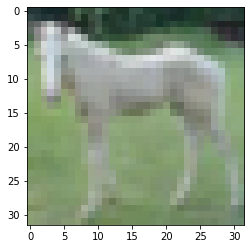

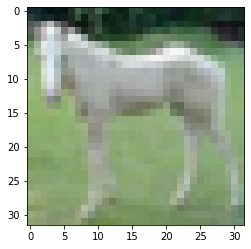

predicted horse
true horse
****************************************************************************************************


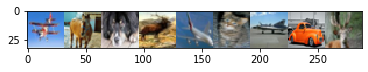

tensor([5.3948e-05, 7.1422e-01, 6.6738e-05, 3.3521e-02, 8.2562e-02, 1.4550e-02,
        6.8885e-02, 8.5649e-02, 4.9410e-04], device='cuda:0',
       dtype=torch.float64)


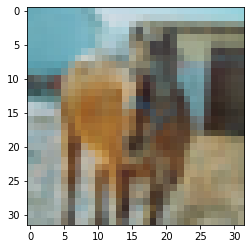

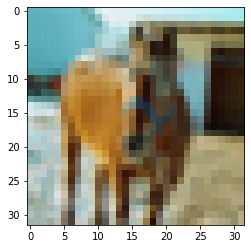

predicted horse
true horse
****************************************************************************************************


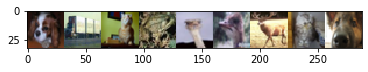

tensor([1.1842e-03, 9.4844e-01, 3.2468e-03, 2.5302e-06, 8.0241e-03, 3.1217e-02,
        2.5910e-04, 6.7058e-03, 9.2481e-04], device='cuda:0',
       dtype=torch.float64)


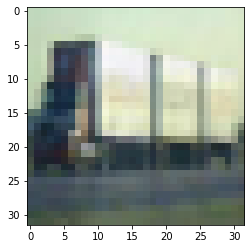

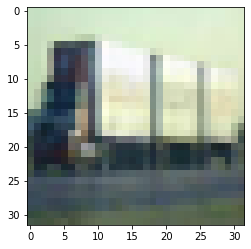

predicted truck
true truck
****************************************************************************************************


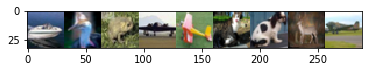

tensor([7.4853e-01, 2.8652e-04, 4.0597e-04, 8.7950e-02, 2.7335e-02, 2.1767e-02,
        5.0966e-02, 2.5591e-03, 6.0199e-02], device='cuda:0',
       dtype=torch.float64)


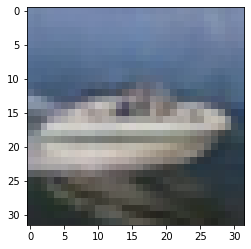

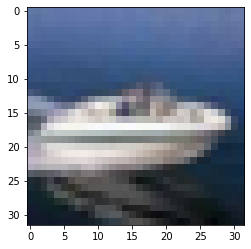

predicted ship
true ship
****************************************************************************************************


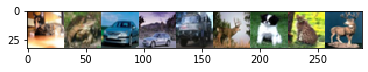

tensor([4.8751e-03, 5.9485e-03, 1.4015e-02, 2.7058e-02, 7.5762e-01, 3.3501e-03,
        2.9180e-03, 9.4741e-06, 1.8421e-01], device='cuda:0',
       dtype=torch.float64)


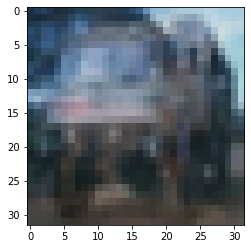

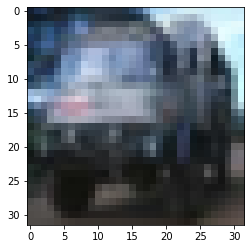

predicted truck
true truck
Accuracy of the network on the 30000 train images: 94 %
total correct 28417
total train set images 30000
focus_true_pred_true 39
focus_false_pred_true 6
focus_true_pred_false 0
focus_false_pred_false 5
argmax_more_than_half 42
argmax_less_than_half 8


In [133]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1.cpu())

        print(alphas[j])

        img2 = avg_images[j]
        display(img2.cpu())

        img3 = inputs[j][fore_idx[j]]
        display(img3.cpu())

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])
        
        focus = torch.argmax(alphas[j])
      
        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

      flag =0

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
    bg_idx = np.random.randint(0,35000,8)
    fg_idx = np.random.randint(0,15000)
    fg = np.random.randint(0,9)
    fore_idx_test.append(fg)
    image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
    test_images.append(image_list)
    test_label.append(label)

In [0]:
# test_data = MosaicDataset(test_images,test_label,)
# test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

3


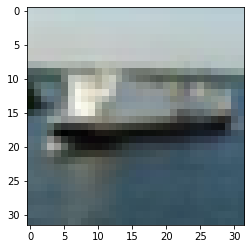

ship


In [136]:
print(fore_idx_test[0])
imshow(test_images[0][fore_idx_test[0]])
print(classes[test_label[0]+7])

****************************************************************************************************


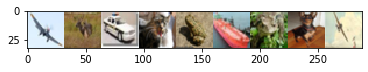

tensor([1.0203e-03, 2.5037e-04, 9.7524e-03, 1.3158e-02, 3.5169e-03, 8.4597e-01,
        6.7821e-03, 1.1274e-01, 6.8081e-03], device='cuda:0',
       dtype=torch.float64)


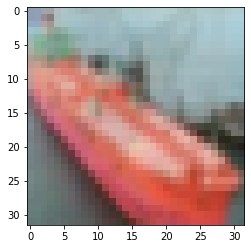

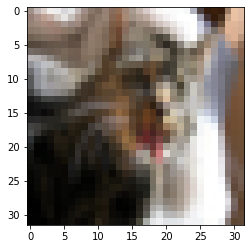

predicted ship
true ship
****************************************************************************************************


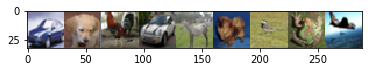

tensor([1.9591e-02, 7.6009e-03, 7.5276e-02, 5.5008e-03, 8.6796e-01, 4.4805e-03,
        4.8070e-04, 1.0415e-03, 1.8068e-02], device='cuda:0',
       dtype=torch.float64)


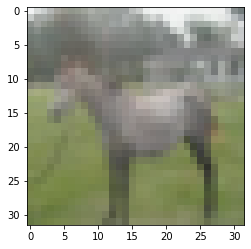

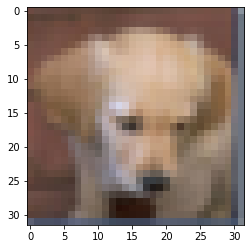

predicted horse
true horse
****************************************************************************************************


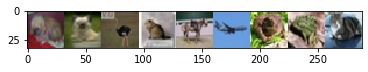

tensor([1.4399e-03, 8.5915e-04, 3.8821e-03, 9.9094e-02, 2.4460e-01, 6.1816e-04,
        3.6651e-03, 2.9626e-04, 6.4554e-01], device='cuda:0',
       dtype=torch.float64)


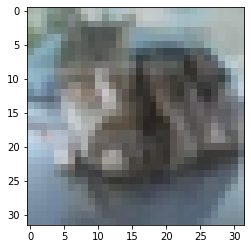

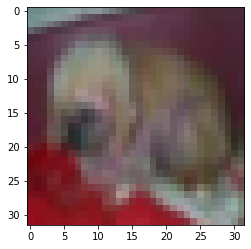

predicted ship
true horse
****************************************************************************************************


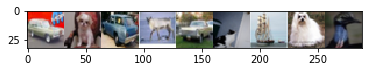

tensor([0.0068, 0.0101, 0.0974, 0.2063, 0.0879, 0.0011, 0.4233, 0.0022, 0.1649],
       device='cuda:0', dtype=torch.float64)


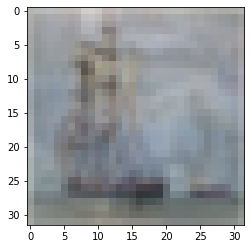

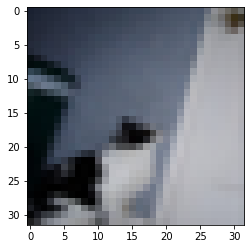

predicted ship
true ship
****************************************************************************************************


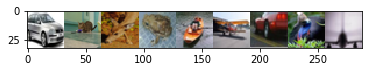

tensor([3.7315e-02, 2.2468e-02, 1.6655e-04, 7.0592e-04, 4.9404e-03, 5.5295e-01,
        2.0136e-01, 7.5963e-02, 1.0414e-01], device='cuda:0',
       dtype=torch.float64)


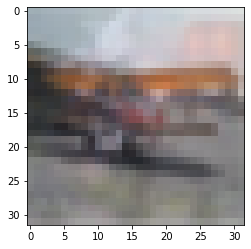

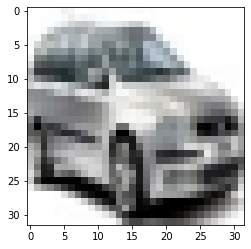

predicted truck
true ship
****************************************************************************************************


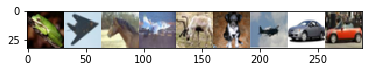

tensor([8.1252e-03, 3.0975e-04, 1.1476e-01, 4.2148e-01, 3.7592e-02, 2.4158e-01,
        1.9863e-02, 7.6027e-02, 8.0267e-02], device='cuda:0',
       dtype=torch.float64)


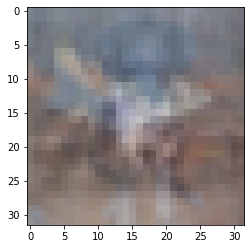

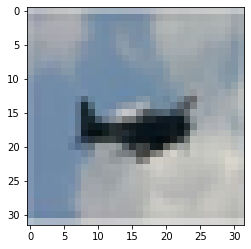

predicted truck
true horse
****************************************************************************************************


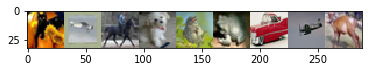

tensor([3.4615e-04, 1.6906e-01, 6.7472e-01, 1.8074e-02, 3.0152e-03, 3.9908e-03,
        2.8116e-02, 3.6493e-03, 9.9025e-02], device='cuda:0',
       dtype=torch.float64)


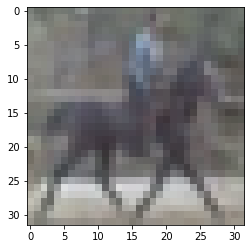

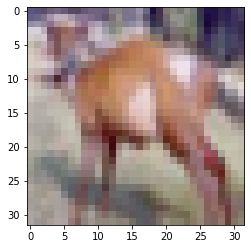

predicted horse
true horse
****************************************************************************************************


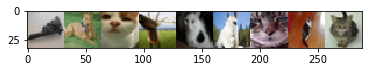

tensor([5.5354e-01, 2.8432e-03, 8.5943e-02, 4.8568e-02, 1.5513e-05, 2.8958e-01,
        8.1604e-04, 9.8938e-04, 1.7708e-02], device='cuda:0',
       dtype=torch.float64)


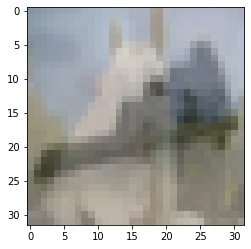

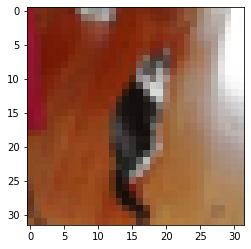

predicted horse
true horse
****************************************************************************************************


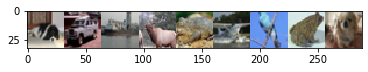

tensor([1.2490e-02, 8.9765e-03, 8.9696e-01, 2.5522e-02, 2.8574e-03, 1.9686e-02,
        4.5598e-04, 4.8572e-03, 2.8198e-02], device='cuda:0',
       dtype=torch.float64)


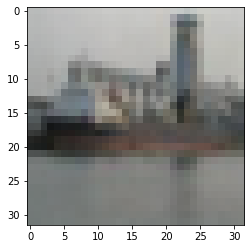

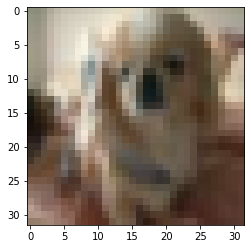

predicted ship
true ship
****************************************************************************************************


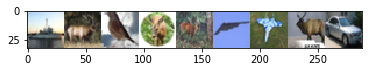

tensor([0.7188, 0.0333, 0.0122, 0.0228, 0.1628, 0.0318, 0.0027, 0.0034, 0.0122],
       device='cuda:0', dtype=torch.float64)


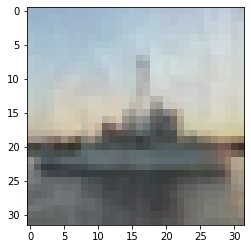

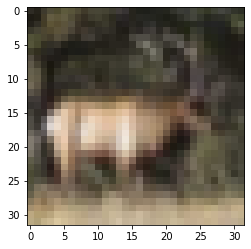

predicted ship
true ship
****************************************************************************************************


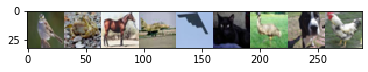

tensor([0.0139, 0.1876, 0.1919, 0.0705, 0.0104, 0.2029, 0.0735, 0.1625, 0.0868],
       device='cuda:0', dtype=torch.float64)


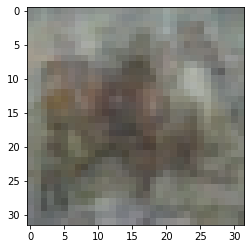

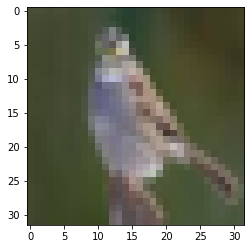

predicted horse
true horse
****************************************************************************************************


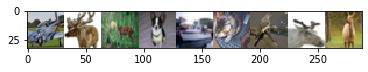

tensor([7.6401e-02, 2.6492e-02, 4.1809e-03, 4.6045e-04, 8.5230e-01, 1.2634e-02,
        1.2237e-03, 2.6273e-02, 3.2783e-05], device='cuda:0',
       dtype=torch.float64)


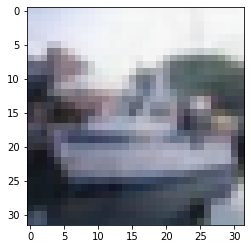

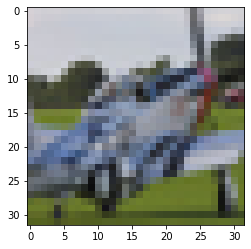

predicted ship
true ship
****************************************************************************************************


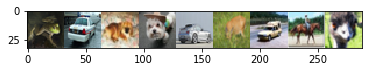

tensor([2.0269e-03, 4.7610e-05, 1.0347e-03, 4.2779e-03, 7.0546e-02, 3.0451e-05,
        8.2427e-03, 9.1254e-01, 1.2546e-03], device='cuda:0',
       dtype=torch.float64)


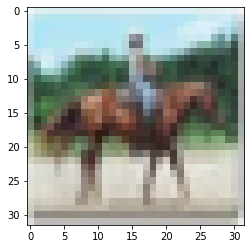

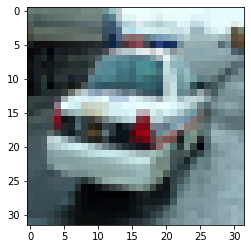

predicted horse
true horse
****************************************************************************************************


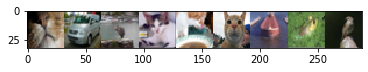

tensor([8.5611e-03, 2.1617e-02, 1.1400e-02, 5.4091e-03, 3.1506e-03, 1.2444e-03,
        9.3058e-01, 7.6756e-06, 1.8031e-02], device='cuda:0',
       dtype=torch.float64)


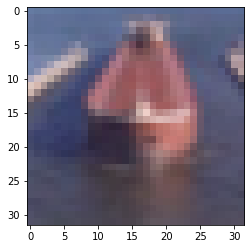

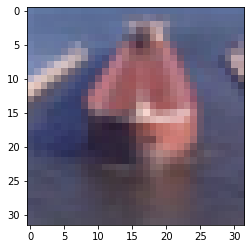

predicted ship
true ship
****************************************************************************************************


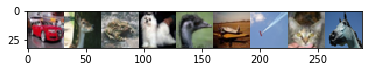

tensor([2.8453e-02, 1.0108e-02, 6.1078e-01, 5.4302e-04, 1.0540e-01, 1.1845e-01,
        6.2399e-02, 1.6031e-03, 6.2258e-02], device='cuda:0',
       dtype=torch.float64)


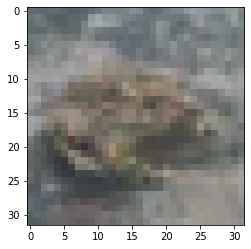

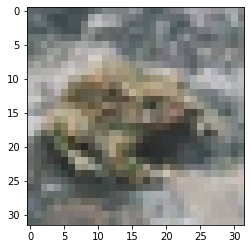

predicted truck
true horse
****************************************************************************************************


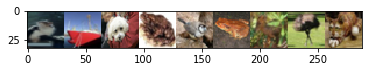

tensor([0.0898, 0.1985, 0.0036, 0.6532, 0.0024, 0.0036, 0.0145, 0.0019, 0.0324],
       device='cuda:0', dtype=torch.float64)


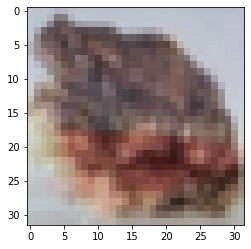

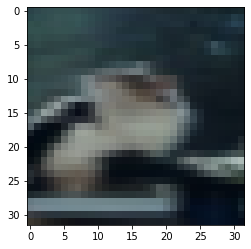

predicted horse
true ship
****************************************************************************************************


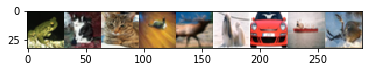

tensor([2.0775e-04, 1.8389e-02, 2.2151e-03, 4.4890e-04, 1.6538e-02, 3.6174e-02,
        5.5758e-02, 8.6143e-01, 8.8414e-03], device='cuda:0',
       dtype=torch.float64)


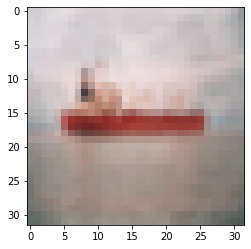

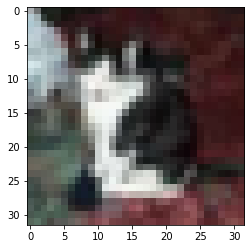

predicted ship
true ship
****************************************************************************************************


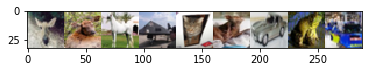

tensor([3.9290e-04, 5.8656e-03, 6.7909e-01, 1.0565e-01, 4.9674e-04, 5.6812e-02,
        2.3811e-02, 7.4330e-03, 1.2045e-01], device='cuda:0',
       dtype=torch.float64)


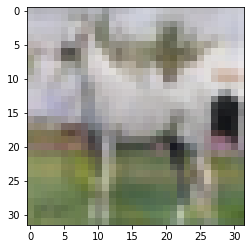

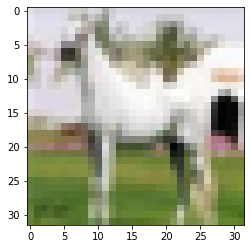

predicted horse
true horse
****************************************************************************************************


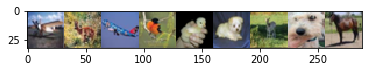

tensor([2.5602e-01, 4.6356e-04, 4.1665e-03, 1.3033e-04, 3.7638e-05, 7.4967e-03,
        8.7503e-03, 2.9203e-02, 6.9373e-01], device='cuda:0',
       dtype=torch.float64)


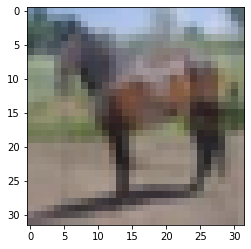

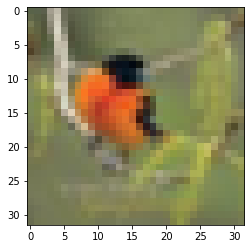

predicted horse
true horse
****************************************************************************************************


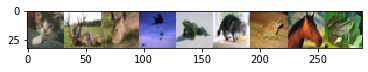

tensor([0.0021, 0.3899, 0.0018, 0.0295, 0.5056, 0.0124, 0.0013, 0.0564, 0.0010],
       device='cuda:0', dtype=torch.float64)


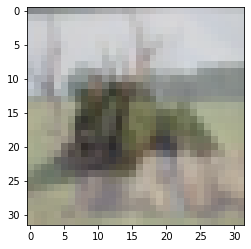

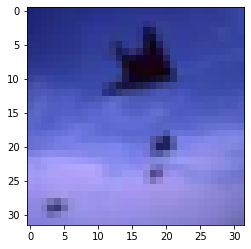

predicted truck
true horse
****************************************************************************************************


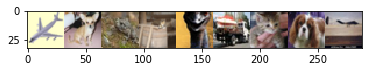

tensor([3.5721e-02, 1.8178e-03, 8.8568e-03, 5.1444e-04, 2.9540e-03, 8.6262e-01,
        1.2009e-02, 1.5974e-02, 5.9531e-02], device='cuda:0',
       dtype=torch.float64)


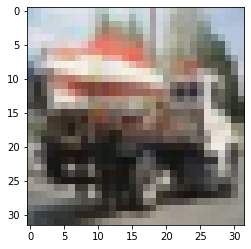

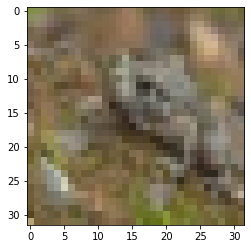

predicted truck
true truck
****************************************************************************************************


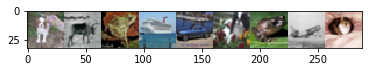

tensor([4.7054e-02, 5.2171e-02, 7.6529e-06, 7.0542e-01, 1.0595e-01, 1.4213e-02,
        3.0366e-03, 7.1636e-02, 5.1175e-04], device='cuda:0',
       dtype=torch.float64)


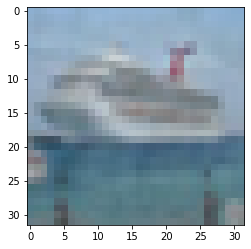

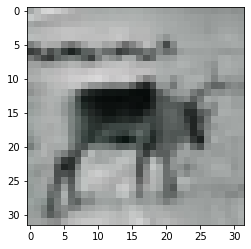

predicted ship
true ship
****************************************************************************************************


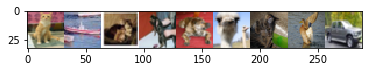

tensor([0.0055, 0.4826, 0.3403, 0.0147, 0.0010, 0.0119, 0.1358, 0.0023, 0.0061],
       device='cuda:0', dtype=torch.float64)


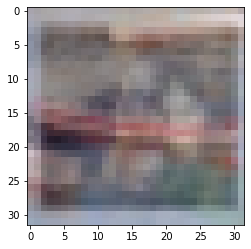

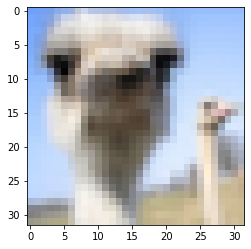

predicted ship
true ship
****************************************************************************************************


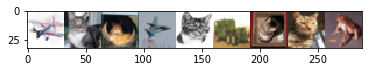

tensor([2.8798e-01, 1.4982e-02, 2.2551e-02, 1.6538e-02, 1.5129e-02, 6.3661e-01,
        2.7744e-03, 9.8877e-05, 3.3379e-03], device='cuda:0',
       dtype=torch.float64)


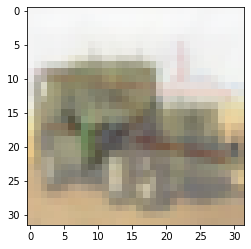

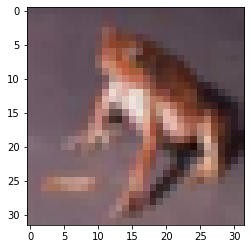

predicted truck
true truck
****************************************************************************************************


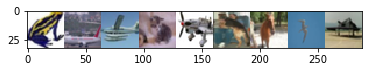

tensor([0.0009, 0.5459, 0.0529, 0.0315, 0.0152, 0.1208, 0.1379, 0.0328, 0.0622],
       device='cuda:0', dtype=torch.float64)


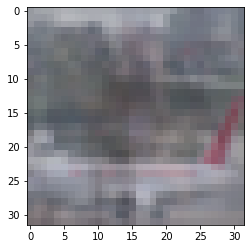

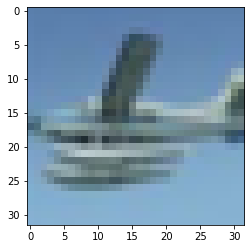

predicted ship
true horse
****************************************************************************************************


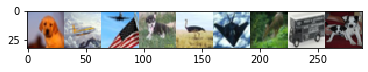

tensor([1.0672e-03, 2.4912e-02, 1.0575e-02, 3.2728e-02, 4.7374e-03, 4.7641e-04,
        1.8850e-03, 9.2191e-01, 1.7136e-03], device='cuda:0',
       dtype=torch.float64)


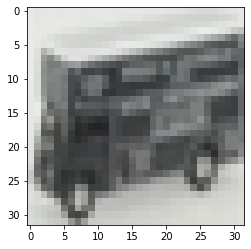

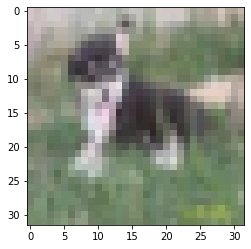

predicted truck
true truck
****************************************************************************************************


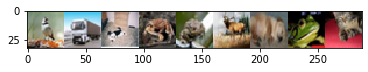

tensor([3.7570e-03, 1.8141e-01, 7.7959e-03, 4.2229e-03, 5.0896e-02, 7.4050e-01,
        4.9435e-03, 4.7813e-04, 6.0023e-03], device='cuda:0',
       dtype=torch.float64)


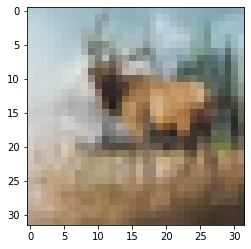

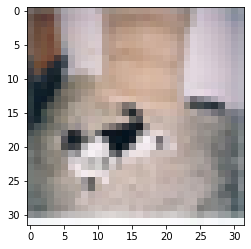

predicted horse
true truck
****************************************************************************************************


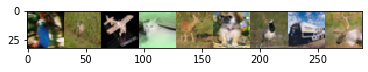

tensor([5.9765e-03, 2.5534e-04, 3.0328e-03, 2.3906e-03, 2.4516e-04, 1.7645e-03,
        1.0422e-03, 9.8527e-01, 1.8065e-05], device='cuda:0',
       dtype=torch.float64)


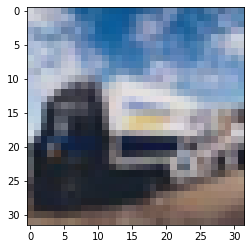

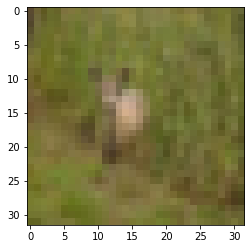

predicted truck
true truck
****************************************************************************************************


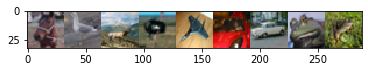

tensor([1.4287e-01, 7.5982e-02, 5.8862e-02, 1.4115e-01, 9.2441e-03, 3.4723e-04,
        1.2219e-01, 4.4604e-01, 3.3091e-03], device='cuda:0',
       dtype=torch.float64)


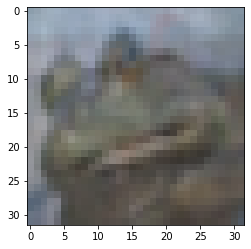

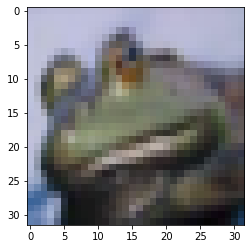

predicted horse
true horse
****************************************************************************************************


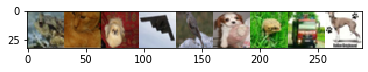

tensor([3.2780e-02, 5.5839e-04, 2.3457e-04, 3.0914e-01, 1.1891e-02, 2.3141e-04,
        1.2383e-03, 5.7739e-01, 6.6539e-02], device='cuda:0',
       dtype=torch.float64)


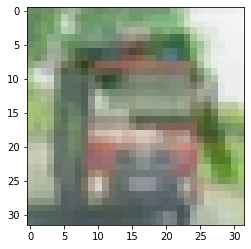

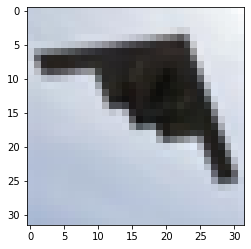

predicted horse
true truck
****************************************************************************************************


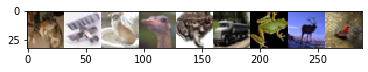

tensor([0.0010, 0.2253, 0.0914, 0.0934, 0.0241, 0.3766, 0.0072, 0.1687, 0.0122],
       device='cuda:0', dtype=torch.float64)


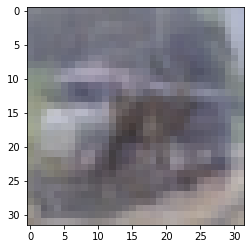

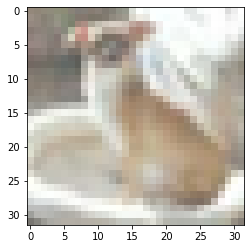

predicted horse
true truck
****************************************************************************************************


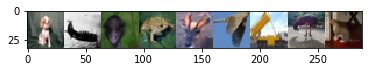

tensor([0.0784, 0.2943, 0.0270, 0.0187, 0.2406, 0.0012, 0.0238, 0.2148, 0.1012],
       device='cuda:0', dtype=torch.float64)


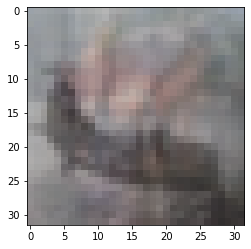

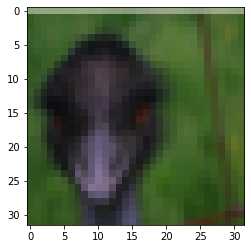

predicted ship
true truck
****************************************************************************************************


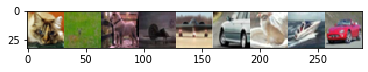

tensor([1.2521e-03, 1.0418e-05, 4.7269e-02, 1.9259e-02, 6.7588e-02, 1.5383e-02,
        5.8932e-03, 8.4310e-01, 2.4239e-04], device='cuda:0',
       dtype=torch.float64)


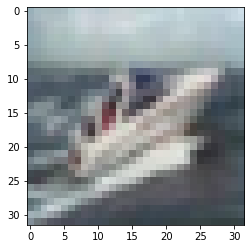

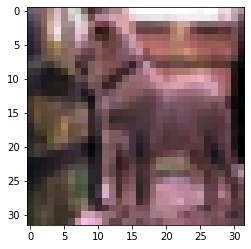

predicted ship
true ship
****************************************************************************************************


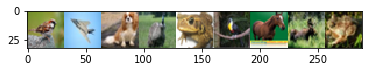

tensor([2.7110e-04, 2.2150e-04, 4.8895e-03, 1.8138e-03, 3.3772e-03, 2.9710e-01,
        6.9006e-01, 2.0340e-03, 2.3131e-04], device='cuda:0',
       dtype=torch.float64)


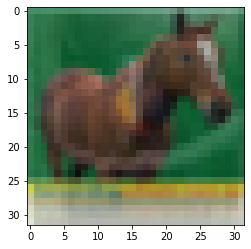

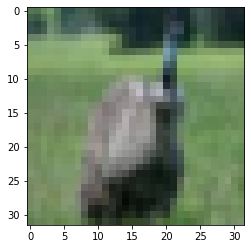

predicted horse
true horse
****************************************************************************************************


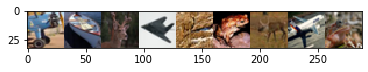

tensor([3.9613e-03, 9.7007e-01, 7.1828e-03, 8.4166e-04, 2.5610e-03, 2.0926e-06,
        9.3573e-04, 1.1612e-03, 1.3281e-02], device='cuda:0',
       dtype=torch.float64)


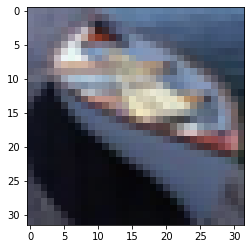

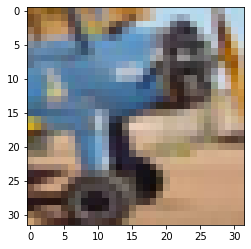

predicted ship
true ship
****************************************************************************************************


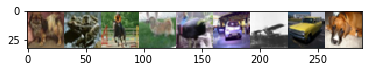

tensor([0.0018, 0.0082, 0.0084, 0.9150, 0.0107, 0.0150, 0.0311, 0.0086, 0.0012],
       device='cuda:0', dtype=torch.float64)


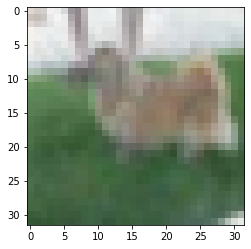

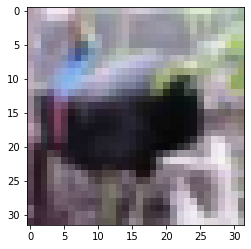

predicted horse
true horse
****************************************************************************************************


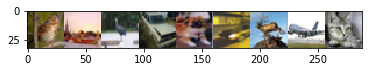

tensor([1.5223e-04, 7.8824e-01, 1.4678e-02, 2.3519e-02, 6.1965e-02, 3.9784e-03,
        3.1323e-02, 3.3963e-02, 4.2178e-02], device='cuda:0',
       dtype=torch.float64)


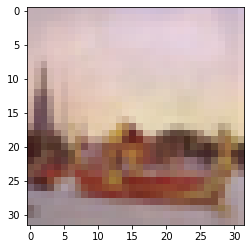

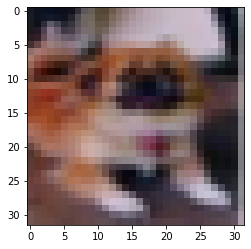

predicted ship
true ship
****************************************************************************************************


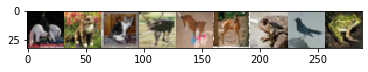

tensor([8.5728e-01, 3.5241e-04, 4.6143e-02, 7.4409e-03, 1.6802e-02, 2.2069e-02,
        3.4088e-03, 4.6444e-02, 5.6315e-05], device='cuda:0',
       dtype=torch.float64)


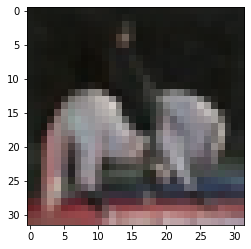

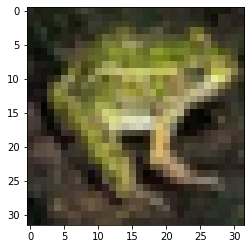

predicted horse
true horse
****************************************************************************************************


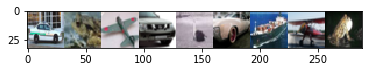

tensor([1.4149e-03, 4.7194e-03, 1.2969e-02, 7.9343e-02, 3.6087e-02, 1.0436e-01,
        6.1199e-01, 1.4909e-01, 2.4624e-05], device='cuda:0',
       dtype=torch.float64)


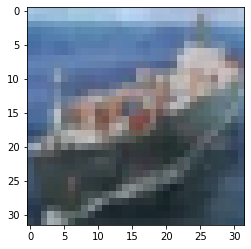

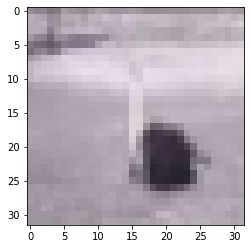

predicted ship
true ship
****************************************************************************************************


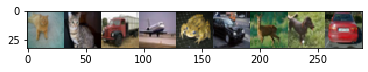

tensor([4.0338e-03, 3.1089e-03, 8.9497e-01, 1.0327e-02, 9.4917e-05, 8.3634e-02,
        2.2422e-03, 5.2445e-04, 1.0671e-03], device='cuda:0',
       dtype=torch.float64)


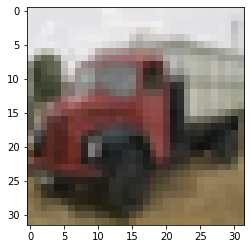

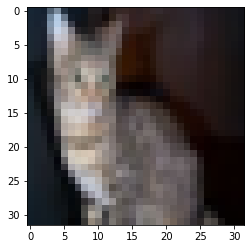

predicted truck
true truck
****************************************************************************************************


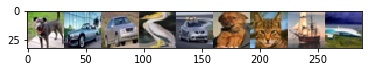

tensor([1.7007e-02, 1.1620e-03, 5.1096e-04, 2.7359e-01, 1.1209e-02, 2.0645e-03,
        4.6960e-04, 6.8316e-01, 1.0834e-02], device='cuda:0',
       dtype=torch.float64)


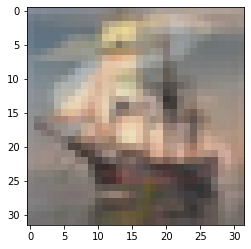

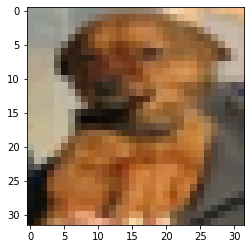

predicted ship
true ship
****************************************************************************************************


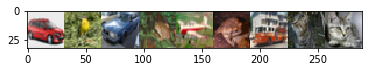

tensor([1.2104e-02, 9.9476e-06, 4.1419e-02, 1.0819e-03, 1.0149e-02, 4.8259e-04,
        8.9998e-01, 1.3334e-02, 2.1440e-02], device='cuda:0',
       dtype=torch.float64)


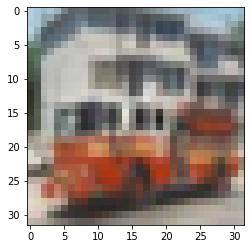

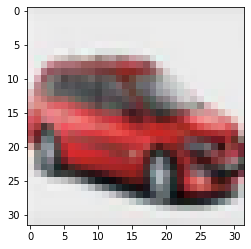

predicted truck
true truck
****************************************************************************************************


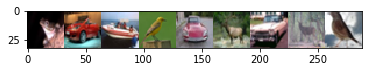

tensor([1.0413e-04, 8.0834e-03, 8.6752e-01, 6.8508e-04, 8.1380e-02, 1.6188e-02,
        7.5033e-03, 1.5394e-02, 3.1448e-03], device='cuda:0',
       dtype=torch.float64)


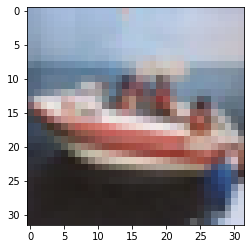

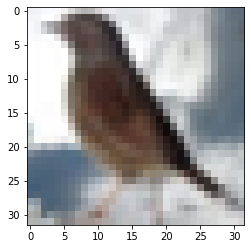

predicted ship
true ship
****************************************************************************************************


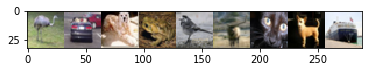

tensor([3.0025e-02, 5.0693e-02, 1.0006e-03, 3.9526e-04, 6.0756e-02, 2.1754e-02,
        7.4948e-02, 1.3432e-03, 7.5909e-01], device='cuda:0',
       dtype=torch.float64)


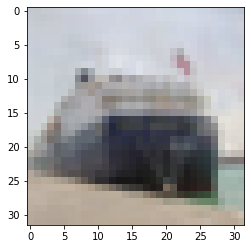

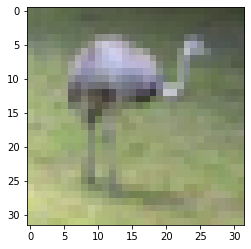

predicted ship
true ship
****************************************************************************************************


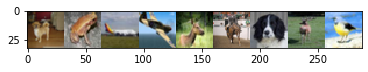

tensor([1.8074e-04, 3.4162e-04, 4.5652e-02, 6.7510e-01, 6.6600e-05, 7.1201e-03,
        2.6866e-01, 1.0826e-03, 1.7934e-03], device='cuda:0',
       dtype=torch.float64)


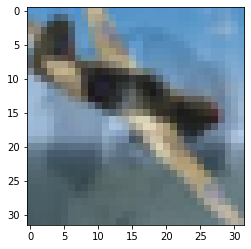

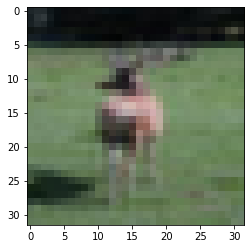

predicted ship
true horse
****************************************************************************************************


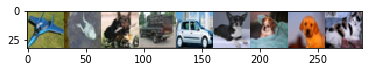

tensor([2.0095e-04, 1.6068e-01, 7.8614e-03, 7.6606e-01, 3.0436e-02, 9.7673e-05,
        4.2426e-05, 3.0328e-03, 3.1594e-02], device='cuda:0',
       dtype=torch.float64)


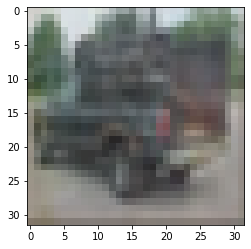

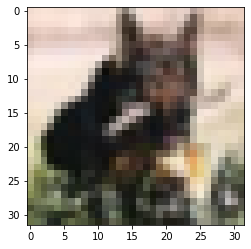

predicted truck
true truck
****************************************************************************************************


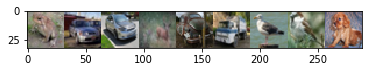

tensor([0.0353, 0.0851, 0.0740, 0.0084, 0.1153, 0.3083, 0.3088, 0.0632, 0.0018],
       device='cuda:0', dtype=torch.float64)


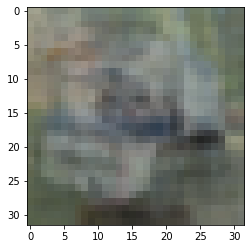

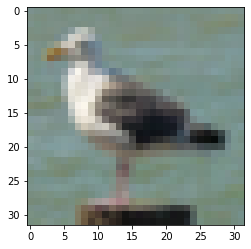

predicted truck
true truck
****************************************************************************************************


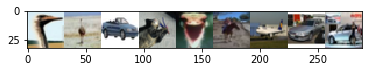

tensor([0.0193, 0.0229, 0.6418, 0.0111, 0.0030, 0.0811, 0.0216, 0.0539, 0.1451],
       device='cuda:0', dtype=torch.float64)


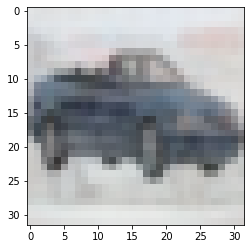

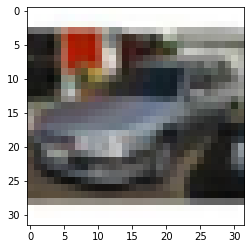

predicted truck
true horse
****************************************************************************************************


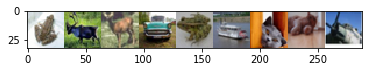

tensor([0.0225, 0.0632, 0.0152, 0.0084, 0.0016, 0.6779, 0.0012, 0.1513, 0.0587],
       device='cuda:0', dtype=torch.float64)


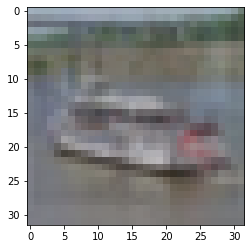

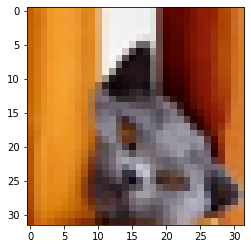

predicted ship
true ship
****************************************************************************************************


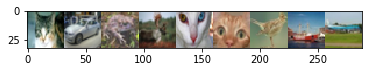

tensor([5.8724e-05, 3.9852e-03, 5.3194e-02, 1.1254e-01, 1.4573e-02, 4.8782e-05,
        8.0982e-04, 8.1110e-01, 3.7000e-03], device='cuda:0',
       dtype=torch.float64)


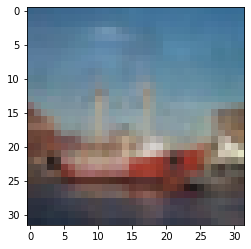

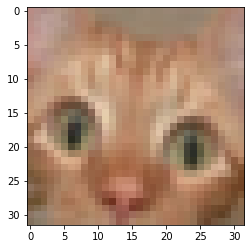

predicted ship
true ship
Accuracy of the network on the 10000 test images: 79 %
total correct 7992
total test set images 10000


In [137]:
correct = 0
total = 0
flag =1
with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)
    _, predicted = torch.max(outputs.data, 1)


    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1.cpu())

        print(alphas[j])

        img2 = avg_images[j]
        display(img2.cpu())

        img3 = inputs[j][fore_idx_test[j]]
        display(img3.cpu())

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])

      flag =0


    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
print("total correct", correct)
print("total test set images", total)

In [0]:
a = torch.tensor([0.0071, 0.0466, 0.0025, 0.0282, 0.0140, 0.0067, 0.0145, 0.8750, 0.0055])

In [139]:
print(torch.argmax(a) == 7)
print(batch)

tensor(True)
250


In [140]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)
    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 94 %
total correct 28417
total train set images 30000
focus_true_pred_true 23088
focus_false_pred_true 5329
focus_true_pred_false 341
focus_false_pred_false 1242
argmax_more_than_half 24797
argmax_less_than_half 5203


In [141]:
bg_idx = np.random.randint(0,35000,8)
fg_idx = np.random.randint(0,15000)
fg = np.random.randint(0,9)
fore_idx_test.append(fg)
image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
test_images.append(image_list)
test_label.append(label)
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)

    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 79 %
total correct 7992
total train set images 10000
focus_true_pred_true 6844
focus_false_pred_true 1148
focus_true_pred_false 487
focus_false_pred_false 1521
argmax_more_than_half 7854
argmax_less_than_half 2146


In [0]:
# epoch = 100
# for i in range(epoch):
#   if (i %40) <20:
#     print("What",i)
#   elif (i%40)>20:
#     print("Where",i)